**  KAGGLE AUTHENTICATION THROUGH UPLOADING API FILE**

In [0]:
import zipfile
from google.colab import auth
auth.authenticate_user()

In [2]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 May 30 08:05 kaggle.json
{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}

In [5]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 5.3MB 10.0MB/s 
     |████████████████████████████████| 112kB 57.5MB/s 
     |████████████████████████████████| 102kB 35.9MB/s 
     |████████████████████████████████| 51kB 26.4MB/s 


**DOWNLOADING AND UNZIPPING FILES**

In [6]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 89.4MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.9MB/s]
 99% 1.29G/1.30G [00:10<00:00, 131MB/s]
100% 1.30G/1.30G [00:10<00:00, 133MB/s]
100% 4.96G/4.98G [00:49<00:00, 138MB/s]
100% 4.98G/4.98G [00:49<00:00, 108MB/s]


In [0]:

zipf = zipfile.ZipFile('../content/train.zip')
zipf.extractall('../content/train')

In [0]:
zipf = zipfile.ZipFile('../content/test.zip')
zipf.extractall('../content/test/test')

In [0]:
zipf = zipfile.ZipFile('../content/train_labels.csv.zip')
zipf.extractall()

In [10]:
# Añadir la extensión .tiff en el csv con los labels, para que el flow_from_dataframe pueda leer las imagenes.
import pandas as pd
df = pd.read_csv('../content/train_labels.csv')

df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x: x+'.tif')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [0]:
# Split en validation/train
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

In [12]:
import keras
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255,
                          #rotation_range=45,
                          horizontal_flip=True,
                          vertical_flip=True
                          )

train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="binary", 
                                            target_size=(96,96), 
                                            batch_size=32)

validation_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                                 directory="../content/train", 
                                                 x_col="id", y_col="label", 
                                                 class_mode="binary", 
                                                 target_size=(96,96), 
                                                 batch_size=32)

import os
test_dir = '../content/test/test'
test_datagen = ImageDataGenerator(rescale=1./255)


print(os.getcwd()+os.path.sep+test_dir)
test_generator = test_datagen.flow_from_directory(
        '../content/test',
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=1,
        class_mode='binary',
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)

Using TensorFlow backend.


Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.
/content/../content/test/test
Found 57458 images belonging to 1 classes.


**NN MODEL**

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [25]:
import numpy as np
num_train_samples = len(train_df)
num_val_samples = len(valid_df)
train_steps = np.ceil(num_train_samples / 32)
val_steps = np.ceil(num_val_samples / 32)


from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
#reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[earlystopper])

Epoch 1/5
5501/5501 [==============================] - 1919s 349ms/step - loss: 0.2484 - acc: 0.9015 - val_loss: 0.5924 - val_acc: 0.7687
Epoch 2/5
5501/5501 [==============================] - 1920s 349ms/step - loss: 0.2336 - acc: 0.9087 - val_loss: 0.2395 - val_acc: 0.9012
Epoch 3/5
5501/5501 [==============================] - 1888s 343ms/step - loss: 0.2214 - acc: 0.9135 - val_loss: 1.1156 - val_acc: 0.7311
Epoch 4/5
5501/5501 [==============================] - 1864s 339ms/step - loss: 0.2132 - acc: 0.9175 - val_loss: 0.4738 - val_acc: 0.8034
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


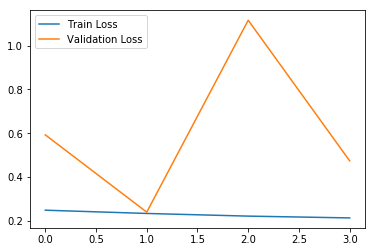

In [26]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

**GENERATE THE PREDICTIONS**





In [0]:
predictions = model.predict_generator(test_generator,steps = nb_samples, verbose=1)

25628/57458 [============>.................] - ETA: 47:10

**UPLOAD THE PREDICTIONS TO KAGGLE**

In [20]:
filenames = test_generator.filenames
filenames = [file.split(sep='/')[1].split(sep='.')[0] for file in filenames]
print(filenames[0:10])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746', '000309e669fa3b18fb0ed6a253a2850cce751a95', '000360e0d8358db520b5c7564ac70c5706a0beb0', '00040095a4a671280aeb66cb0c9231e6216633b5', '000698b7df308d75ec9559ef473a588c513a68aa', '0006e1af5670323331d09880924381d67d79eda0']


In [0]:
results = pd.DataFrame({"id": filenames,
                        "label": predictions.ravel()})

In [23]:
results.to_csv("results.csv",index=False)
print(results.head(5))

                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.807933
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.982708
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.290675
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.039853
4  000270442cc15af719583a8172c87cd2bd9c7746  0.008445


In [24]:
!kaggle competitions submit -c histopathologic-cancer-detection -f results.csv -m "3 filters and binary"

100% 2.85M/2.85M [00:01<00:00, 1.64MB/s]
Successfully submitted to Histopathologic Cancer Detection